Exploratory Data Analysis (EDA) and visualizations for the Telco Customer Churn dataset.
For dataset source, download instructions, and reproducibility steps, see the project README.


In [3]:
# importing libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
# loading data

df = pd.read_csv("data/telco_customer_churn.csv")
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Before proceeding to data cleaning, I will perform a structural audit of the dataset to check for:

1. datatype mismatches
2. Missing values
3. High cardinality


In [5]:
# Check data types and non-null counts
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# Check for duplicate rows
print(f"Total Duplicate Rows: {df.duplicated().sum()}")

Total Duplicate Rows: 0


In [7]:
# Detailed look at missing values
missing_data = df.isnull().sum().to_frame(name='Missing Count')
missing_data['Percentage (%)'] = (missing_data['Missing Count'] / len(df)) * 100
print(missing_data.sort_values(by='Percentage (%)', ascending=False))


                  Missing Count  Percentage (%)
customerID                    0             0.0
gender                        0             0.0
SeniorCitizen                 0             0.0
Partner                       0             0.0
Dependents                    0             0.0
tenure                        0             0.0
PhoneService                  0             0.0
MultipleLines                 0             0.0
InternetService               0             0.0
OnlineSecurity                0             0.0
OnlineBackup                  0             0.0
DeviceProtection              0             0.0
TechSupport                   0             0.0
StreamingTV                   0             0.0
StreamingMovies               0             0.0
Contract                      0             0.0
PaperlessBilling              0             0.0
PaymentMethod                 0             0.0
MonthlyCharges                0             0.0
TotalCharges                  0         

In [8]:

# Identify Unique Values for Categorical Columns
print(df.select_dtypes(include=['object']).nunique())

customerID          7043
gender                 2
Partner                2
Dependents             2
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
TotalCharges        6531
Churn                  2
dtype: int64


1. TotalCharges, CustomerId are actually numerical columns, I am going to cast those to the correct datatype,
2. No categorical variable has very high cardinality
3. Target variable "Churn" currently has class labels: yes or no, I will map those to 1 and 0 for easier calculations


In [9]:

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["SeniorCitizen_label"] = df["SeniorCitizen"].map({0: "No", 1: "Yes"})
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

target = df["Churn"]

In [10]:
#Checking for missing data
missing = df.isna().sum()
missing_only = missing[missing > 0]

if missing_only.empty:
    print("no missing")
else:
    display(missing_only)


TotalCharges    11
dtype: int64

**Note:** `TotalCharges` contains blank strings for some customers. After converting to numeric, these become `NaN`.  
For rows with `tenure == 0`, we set `TotalCharges = 0` because no billing has occurred yet; this avoids dropping new-customer records.


In [11]:
df["TotalCharges"] = df["TotalCharges"].replace(np.nan, 0)

In [12]:
# 1) numeric columns
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# 2) categorical columns
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

# 3) binary categorical columns 
binary_cat = [c for c in cat_cols if df[c].nunique() == 2]

# 4) multi-category categorical columns
multi_cat = [c for c in cat_cols if df[c].nunique() > 2]

print("Numeric:", num_cols)
print("Binary categorical:", binary_cat)
print("Multi-category:", multi_cat)

Numeric: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
Binary categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'SeniorCitizen_label']
Multi-category: ['customerID', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


What do we have till now? (Important ones)
Features:

- Numeric: tenure, Monthly Charges, Total Charges
- Binary(ish): gender,SeniorCitizen_label, Partner, Dependants, PhoneService, PaperlessBilling
- Multi-category: Contract, InternetService, PaymentMethod
- Service Addons: OnlineSecurity, TechSupport, StreamingTV,OnlineBackup, Device Protection, StreamingMovies


In [13]:
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 120,
    "axes.titlesize": 16,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.25,
})

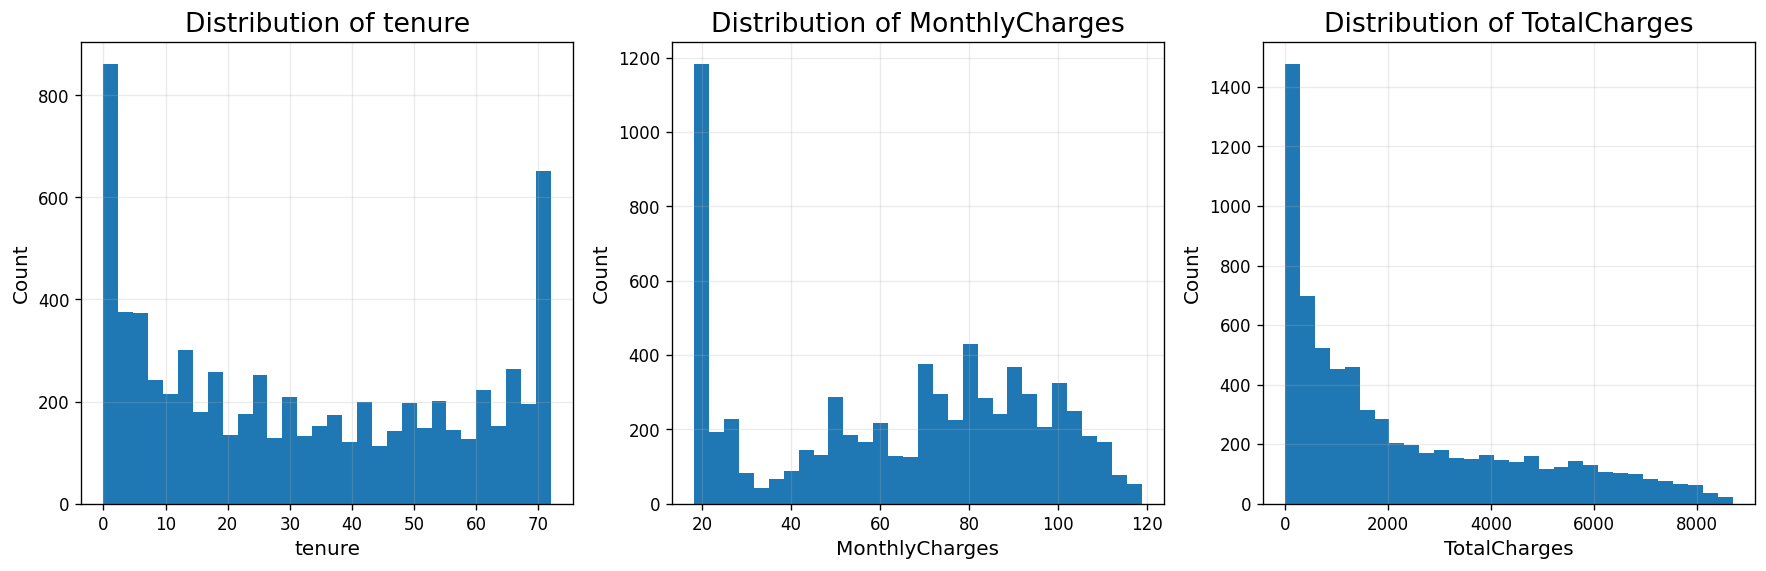

In [14]:
n_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

fig, axes = plt.subplots(1, len(n_cols), figsize=(18, 5))

for ax, col in zip(axes, n_cols):
    ax.hist(df[col].dropna(), bins=30)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

Most people have close to 0 or very low Total and Monthly charges which is due to the fact that tenure is left skewed


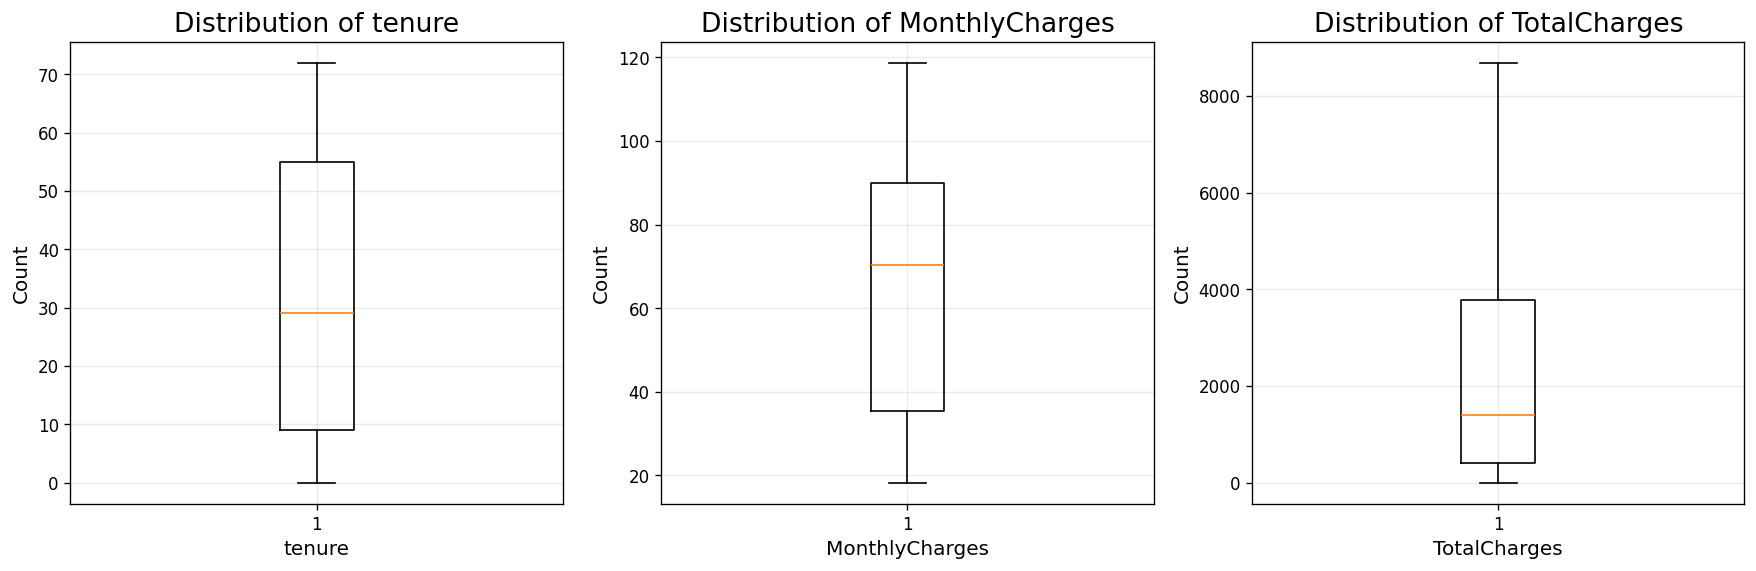

In [15]:
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

fig, axes = plt.subplots(1, len(num_cols), figsize=(18, 5))

for ax, col in zip(axes, n_cols):
    ax.boxplot(df[col].dropna())
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

No visible outliers in the numerical categories


#### Demographics by count


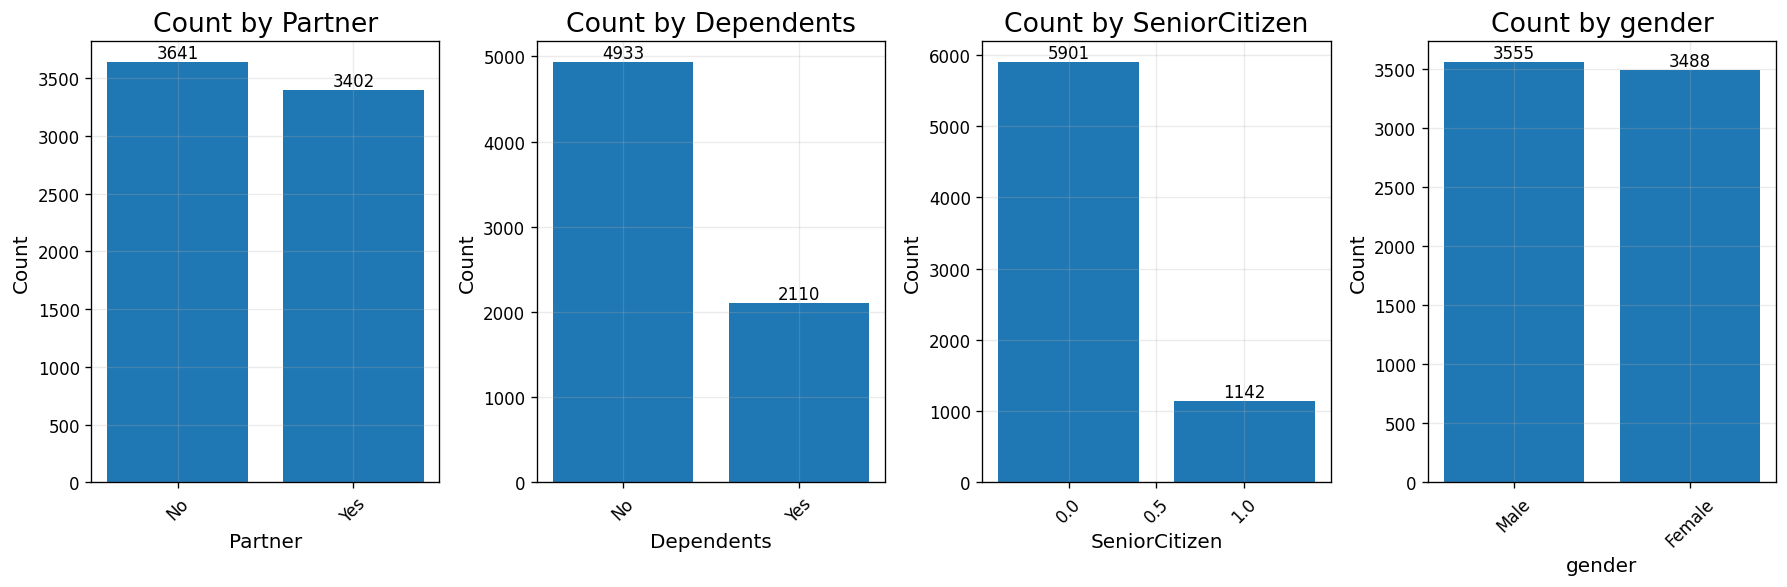

In [16]:
dem = ["Partner", "Dependents", "SeniorCitizen", "gender"]

fig, axes = plt.subplots(1, len(dem), figsize=(15, 5))

for ax, col in zip(axes, dem):
    counts = df[col].value_counts()
    bars = ax.bar(counts.index, counts.values)
    # annotate bars (uses ax.bar_label if available, otherwise falls back to ax.annotate)
    if hasattr(ax, "bar_label"):
        ax.bar_label(bars)
    else:
        for bar in bars:
            h = bar.get_height()
            ax.annotate(f"{int(h)}", xy=(bar.get_x() + bar.get_width() / 2, h),
                        xytext=(0, 3), textcoords="offset points", ha="center", va="bottom")

    ax.set_title(f'Count by {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


About 15 percent of the customers are SeniorCitizens
Insight: Senior Citizens might have different sevice needs or churn patterns


#### Serive add ons by count


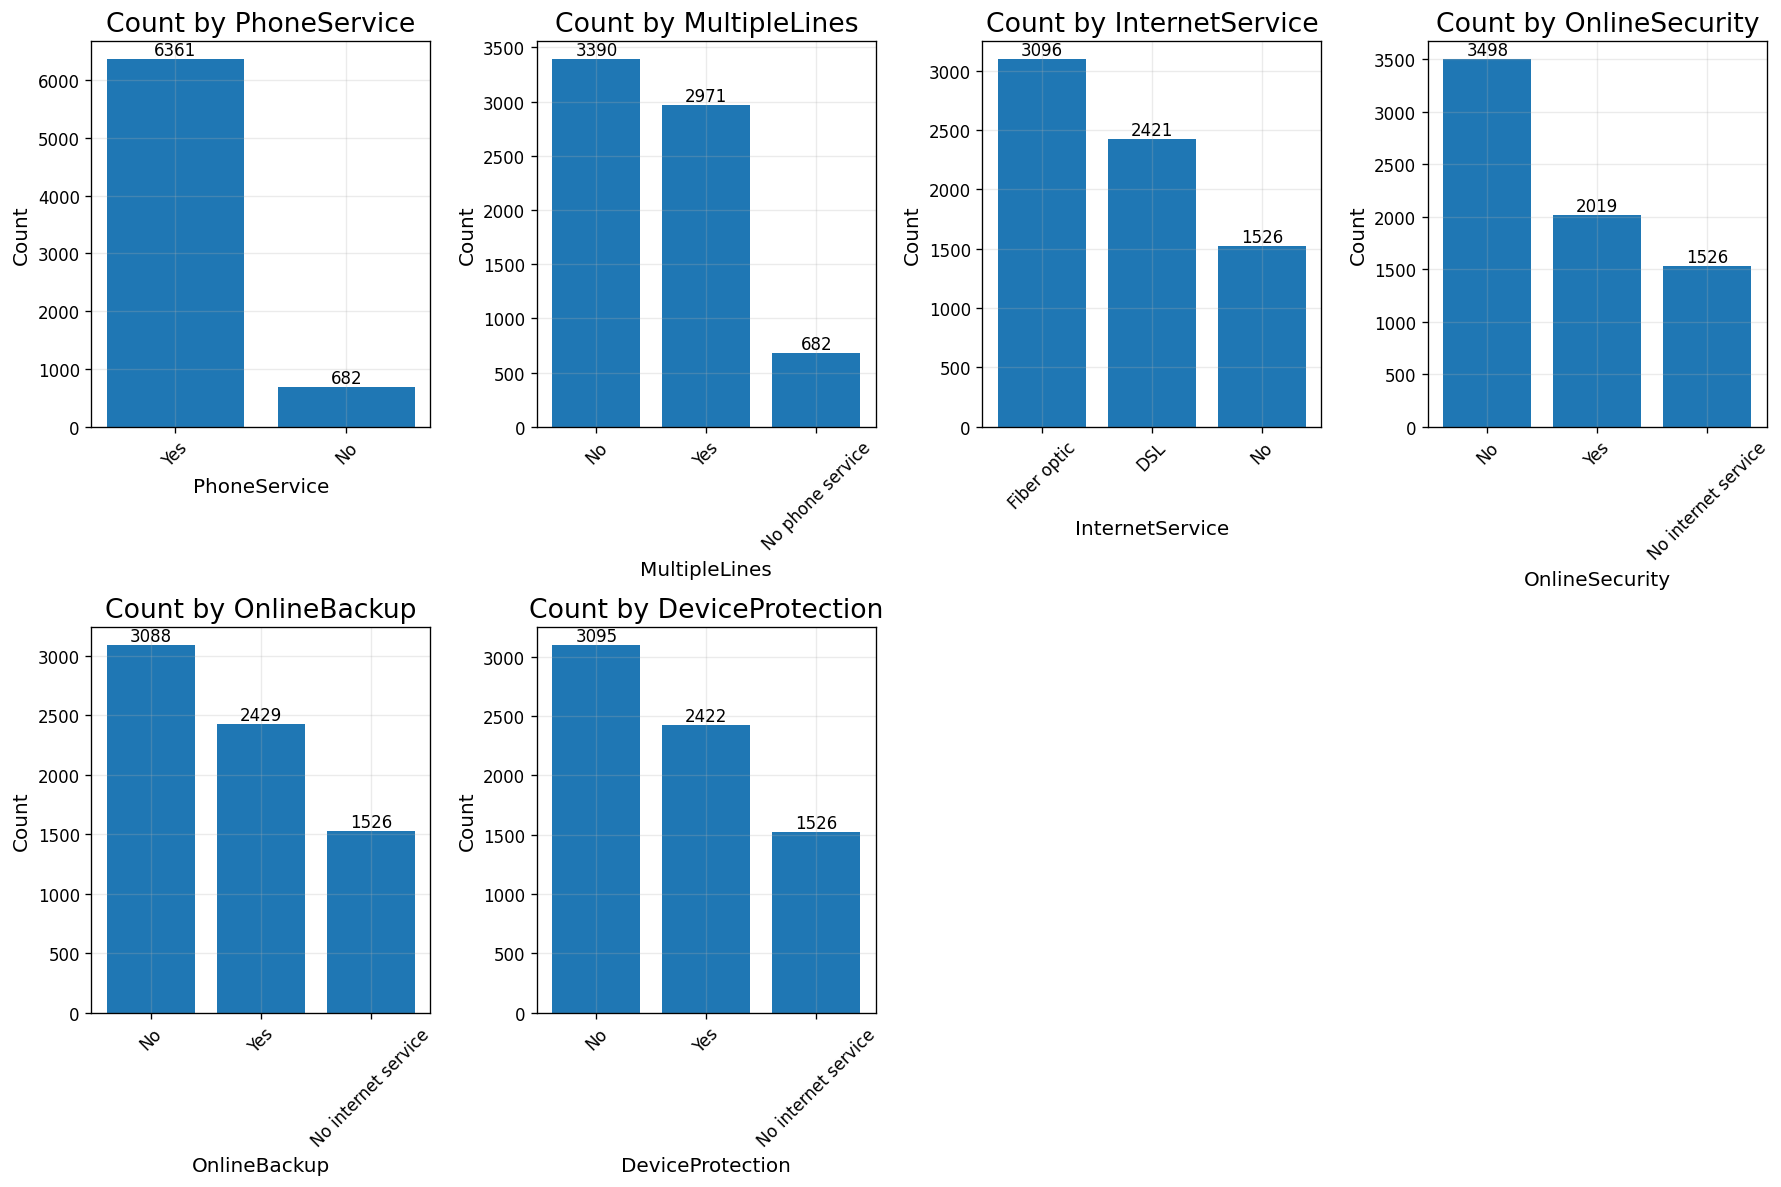

In [17]:

dem = ["PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection"]

n_cols = 4
n_rows = (len(dem) + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

axes = axes.flatten()

for i, (ax, col) in enumerate(zip(axes, dem)):
    counts = df[col].value_counts()
    bars = ax.bar(counts.index, counts.values)
    
    if hasattr(ax, "bar_label"):
        ax.bar_label(bars)
    else:
        for bar in bars:
            h = bar.get_height()
            ax.annotate(f"{int(h)}", xy=(bar.get_x() + bar.get_width() / 2, h),
                        xytext=(0, 3), textcoords="offset points", ha="center", va="bottom")

    ax.set_title(f'Count by {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


Most customers have phone sevice, out of these about one-tenth of the customer base has opted out of internet service


<BarContainer object of 2 artists>

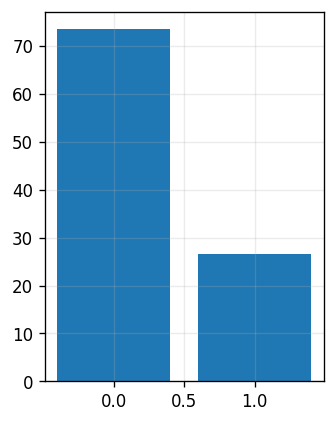

In [18]:
churn_counts = df["Churn"].value_counts(normalize=True)*100
churn_counts

plt.figure(figsize=(3,4))
plt.bar(churn_counts.index, churn_counts.values)


In [19]:
df_numeric = df[["tenure","MonthlyCharges", "TotalCharges","Churn"]]

df_numeric.groupby("Churn").agg(["mean","median","std"])


tenure                   MonthlyCharges                     \
            mean median        std           mean  median        std   
Churn                                                                  
0      37.569965   38.0  24.113777      61.265124  64.425  31.092648   
1      17.979133   10.0  19.531123      74.441332  79.650  24.666053   

      TotalCharges                         
              mean    median          std  
Churn                                      
0      2549.911442  1679.525  2329.954215  
1      1531.796094   703.550  1890.822994

## Numerical Features vs Churn Rate


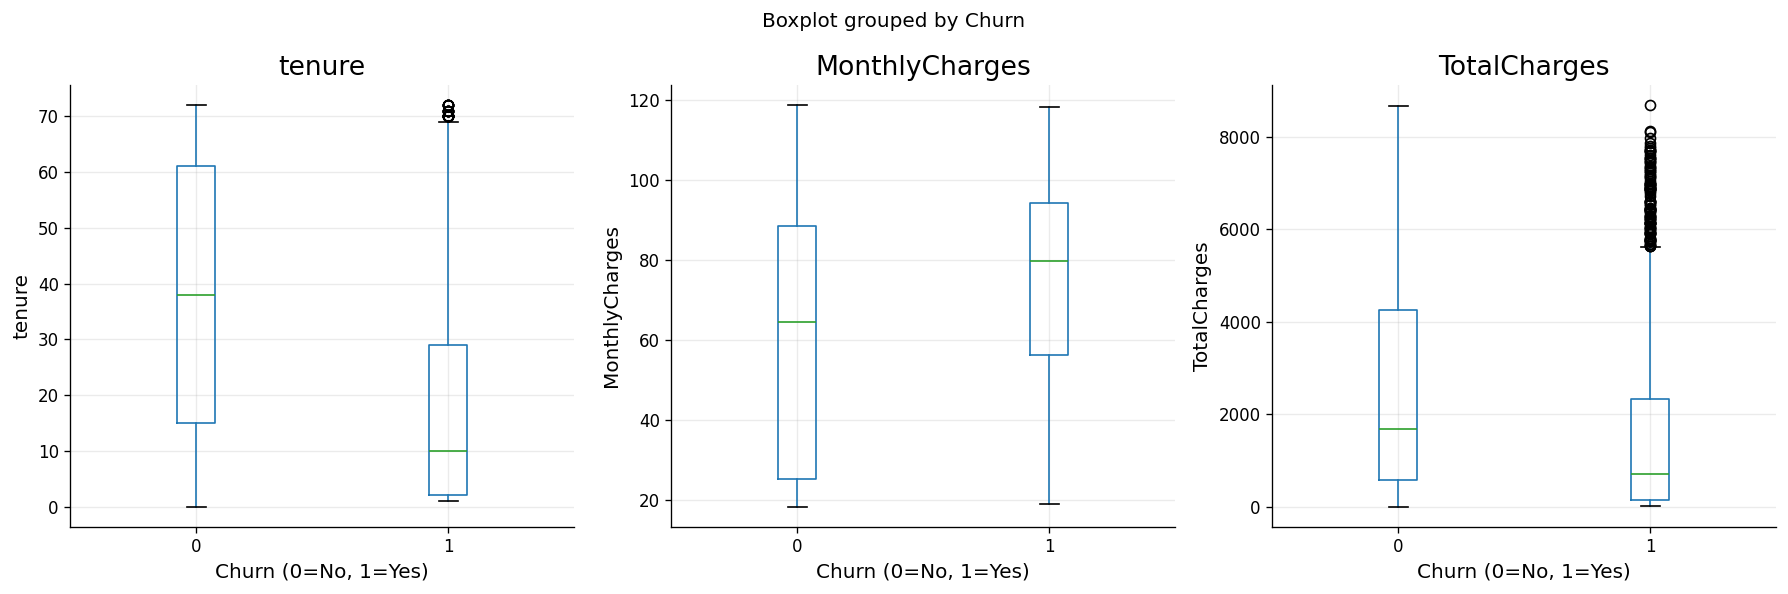

In [20]:
fig, axes = plt.subplots(1, len(num_cols), figsize=(5*len(num_cols), 5))
if len(num_cols) == 1:
    axes = [axes]

for ax, col in zip(axes, num_cols):
    df.boxplot(column=col, by="Churn", ax=ax)
    ax.set_title(col)
    ax.set_xlabel("Churn (0=No, 1=Yes)")
    ax.set_ylabel(col)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

From this we can observe that:

1. Customers with longer tenure are less likely to churn
2. Churners pay higher Monthlychargers than non-churners
3. The outliers in the Total Charges indicate, high risk high value customers i.e they bring in a lot of money but are also likely to leave


<Axes: >

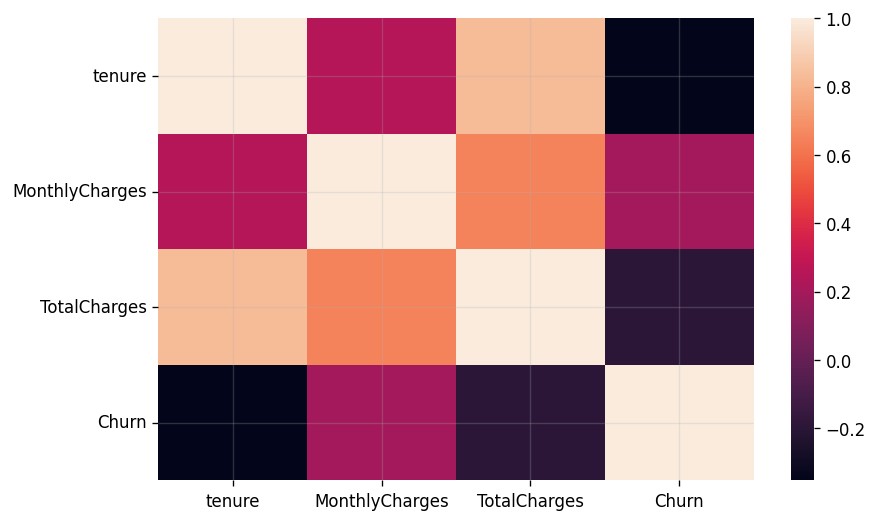

In [21]:
sns.heatmap(df_numeric.corr())

## Heatmap: what it suggests (and what it does _not_)

- Correlation shows **linear association**, not causation.
- In this dataset, you typically see **tenure** and **TotalCharges** correlated because TotalCharges accumulates over time.
- A strong correlation between two features can mean **redundancy** (useful for feature selection later).
- Features with near‑zero correlation to churn may still matter because churn can be **non‑linear** and influenced by interactions.


## Churn rate by **Contract × InternetService**


In [22]:
import pandas as pd
import numpy as np

# Expect a dataframe named df from earlier cells
if "df" not in globals():
    raise NameError("df not found. Please run the notebook cells above (data loading/cleaning) first.")

# Normalize churn to 0/1 for analysis
if df["Churn"].dtype == object:
    churn01 = df["Churn"].map({"Yes": 1, "No": 0})
else:
    churn01 = df["Churn"].astype(int)

tmp = df.copy()
tmp["_churn01"] = churn01

# Pivot table of churn rate and counts
pivot_rate = pd.pivot_table(
    tmp,
    values="_churn01",
    index="Contract",
    columns="InternetService",
    aggfunc="mean"
) * 100

pivot_count = pd.pivot_table(
    tmp,
    values="_churn01",
    index="Contract",
    columns="InternetService",
    aggfunc="count"
)

display(pivot_rate.round(2))
display(pivot_count)


InternetService,DSL,Fiber optic,No
Contract,,,
Month-to-month,32.22,54.61,18.89
One year,9.30,19.29,2.47
Two year,1.91,7.23,0.78


InternetService,DSL,Fiber optic,No
Contract,,,
Month-to-month,1223,2128,524
One year,570,539,364
Two year,628,429,638


## Churn rate (%) for key categorical features


In [23]:
def churn_table(df, col, churn_col="Churn", min_count=30):
    d = df.copy()
    if d[churn_col].dtype == object:
        d["_churn01"] = d[churn_col].map({"Yes": 1, "No": 0})
    else:
        d["_churn01"] = d[churn_col].astype(int)

    out = (
        d.groupby(col)["_churn01"]
        .agg(count="count", churn_rate="mean")
        .reset_index()
    )
    out["churn_rate"] = (out["churn_rate"] * 100).round(2)
    out = out.sort_values(["churn_rate", "count"], ascending=[False, False])

    if min_count is not None:
        out = out[out["count"] >= min_count]
    return out

key_cats = [
    "Contract",
    "PaymentMethod",
    "InternetService",
    "TechSupport",
    "OnlineSecurity",
    "PaperlessBilling",
    "Partner",
    "Dependents"
]

for col in key_cats:
    if col in df.columns:
        print(f"\n--- {col} ---")
        display(churn_table(df, col, min_count=30))



--- Contract ---


,Contract,count,churn_rate
0,Month-to-month,3875,42.71
1,One year,1473,11.27
2,Two year,1695,2.83



--- PaymentMethod ---


,PaymentMethod,count,churn_rate
2,Electronic check,2365,45.29
3,Mailed check,1612,19.11
0,Bank transfer (automatic),1544,16.71
1,Credit card (automatic),1522,15.24



--- InternetService ---


,InternetService,count,churn_rate
1,Fiber optic,3096,41.89
0,DSL,2421,18.96
2,No,1526,7.40



--- TechSupport ---


,TechSupport,count,churn_rate
0,No,3473,41.64
2,Yes,2044,15.17
1,No internet service,1526,7.40



--- OnlineSecurity ---


,OnlineSecurity,count,churn_rate
0,No,3498,41.77
2,Yes,2019,14.61
1,No internet service,1526,7.40



--- PaperlessBilling ---


,PaperlessBilling,count,churn_rate
1,Yes,4171,33.57
0,No,2872,16.33



--- Partner ---


,Partner,count,churn_rate
0,No,3641,32.96
1,Yes,3402,19.66



--- Dependents ---


,Dependents,count,churn_rate
0,No,4933,31.28
1,Yes,2110,15.45


## Add‑on services vs churn (filtered to customers with InternetService)


In [24]:
addon_cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
present = [c for c in addon_cols if c in df.columns]

# Filter out InternetService == "No" because many add-on columns become 'No internet service' and distort comparisons
df_net = df.copy()
if "InternetService" in df_net.columns:
    df_net = df_net[df_net["InternetService"] != "No"]

for col in present:
    print(f"\n--- {col} (InternetService != 'No') ---")
    display(churn_table(df_net, col, min_count=30))



--- OnlineSecurity (InternetService != 'No') ---


,OnlineSecurity,count,churn_rate
0,No,3498,41.77
1,Yes,2019,14.61



--- OnlineBackup (InternetService != 'No') ---


,OnlineBackup,count,churn_rate
0,No,3088,39.93
1,Yes,2429,21.53



--- DeviceProtection (InternetService != 'No') ---


,DeviceProtection,count,churn_rate
0,No,3095,39.13
1,Yes,2422,22.50



--- TechSupport (InternetService != 'No') ---


,TechSupport,count,churn_rate
0,No,3473,41.64
1,Yes,2044,15.17



--- StreamingTV (InternetService != 'No') ---


,StreamingTV,count,churn_rate
0,No,2810,33.52
1,Yes,2707,30.07



--- StreamingMovies (InternetService != 'No') ---


,StreamingMovies,count,churn_rate
0,No,2785,33.68
1,Yes,2732,29.94


## Consolidated: highest‑risk segments (with minimum sample size)


In [25]:
def top_risk_segments(df, cols, min_count=50, top_n=10):
    rows = []
    for col in cols:
        if col not in df.columns:
            continue
        tab = churn_table(df, col, min_count=min_count)
        if tab.empty:
            continue
        tab = tab.head(top_n).copy()
        tab.insert(0, "feature", col)
        tab.rename(columns={col: "segment"}, inplace=True)
        rows.append(tab)
    if not rows:
        return pd.DataFrame(columns=["feature", "segment", "count", "churn_rate"])
    out = pd.concat(rows, ignore_index=True)
    out = out.sort_values("churn_rate", ascending=False).reset_index(drop=True)
    return out

risk_cols = ["Contract", "PaymentMethod", "InternetService", "TechSupport", "OnlineSecurity", "PaperlessBilling", "Partner", "Dependents"]
risk_table = top_risk_segments(df, risk_cols, min_count=50, top_n=5)

display(risk_table)


,feature,segment,count,churn_rate
0,PaymentMethod,Electronic check,2365,45.29
1,Contract,Month-to-month,3875,42.71
2,InternetService,Fiber optic,3096,41.89
3,OnlineSecurity,No,3498,41.77
4,TechSupport,No,3473,41.64
5,PaperlessBilling,Yes,4171,33.57
6,Partner,No,3641,32.96
7,Dependents,No,4933,31.28
8,Partner,Yes,3402,19.66
9,PaymentMethod,Mailed check,1612,19.11


## Quick summary metrics + “high‑risk, high‑value” churners


In [26]:
# Basic summary comparisons
d = df.copy()
if d["Churn"].dtype == object:
    d["_churn01"] = d["Churn"].map({"Yes": 1, "No": 0})
else:
    d["_churn01"] = d["Churn"].astype(int)

def safe_numeric(col):
    if col not in d.columns:
        return None
    x = pd.to_numeric(d[col], errors="coerce")
    return x

tenure = safe_numeric("tenure")
monthly = safe_numeric("MonthlyCharges")
total = safe_numeric("TotalCharges")

summary = {}

if tenure is not None:
    summary["tenure_median_churn_yes"] = float(np.nanmedian(tenure[d["_churn01"]==1]))
    summary["tenure_median_churn_no"]  = float(np.nanmedian(tenure[d["_churn01"]==0]))

if monthly is not None:
    summary["monthly_mean_churn_yes"] = float(np.nanmean(monthly[d["_churn01"]==1]))
    summary["monthly_mean_churn_no"]  = float(np.nanmean(monthly[d["_churn01"]==0]))

if total is not None:
    summary["total_median_churn_yes"] = float(np.nanmedian(total[d["_churn01"]==1]))
    summary["total_median_churn_no"]  = float(np.nanmedian(total[d["_churn01"]==0]))

pd.Series(summary).round(2)


tenure_median_churn_yes      10.00
tenure_median_churn_no       38.00
monthly_mean_churn_yes       74.44
monthly_mean_churn_no        61.27
total_median_churn_yes      703.55
total_median_churn_no      1679.52
dtype: float64

In [27]:
# "High-risk, high-value" churners: churned customers who also have high TotalCharges
if total is None:
    print("TotalCharges not available to compute high-value churners.")
else:
    # Top decile among ALL customers (you can change to top quartile if you want)
    thresh = np.nanpercentile(total, 90)

    high_value_churners = d[(d["_churn01"]==1) & (total >= thresh)]
    total_churners = (d["_churn01"]==1).sum()

    print(f"High-value threshold (90th percentile of TotalCharges): {thresh:.2f}")
    print(f"High-risk high-value churners: {len(high_value_churners)} out of {int(total_churners)} churners "
          f"({(len(high_value_churners)/max(total_churners,1))*100:.2f}%)")

    # Show a small sample (useful for investigation)
    cols_show = [c for c in ["customerID","tenure","MonthlyCharges","TotalCharges","Contract","InternetService","PaymentMethod","TechSupport","OnlineSecurity"] if c in d.columns]
    display(high_value_churners[cols_show].head(10))


High-value threshold (90th percentile of TotalCharges): 5973.69
High-risk high-value churners: 88 out of 1869 churners (4.71%)


,customerID,tenure,MonthlyCharges,TotalCharges,Contract,InternetService,PaymentMethod,TechSupport,OnlineSecurity
104,3192-NQECA,68,110.00,7611.85,Two year,Fiber optic,Bank transfer (automatic),Yes,No
339,1343-EHPYB,63,103.40,6603.00,Month-to-month,Fiber optic,Electronic check,No,No
402,0979-PHULV,69,99.45,7007.60,Month-to-month,Fiber optic,Credit card (automatic),No,No
445,7752-XUSCI,60,105.90,6396.45,Month-to-month,Fiber optic,Electronic check,No,No
609,3419-SNJJD,65,105.25,6786.40,Month-to-month,Fiber optic,Bank transfer (automatic),No,Yes
635,7207-RMRDB,65,105.50,6985.65,Month-to-month,Fiber optic,Electronic check,No,No
799,3009-JWMPU,62,96.75,6125.40,One year,Fiber optic,Electronic check,No,No
810,2239-JALAW,58,103.25,6017.65,One year,Fiber optic,Bank transfer (automatic),No,No
811,4853-RULSV,70,104.00,7250.15,Two year,Fiber optic,Credit card (automatic),Yes,Yes
855,2382-BCKQJ,62,100.15,6413.65,One year,Fiber optic,Electronic check,No,No


## Conclusions (EDA) + Next Steps

**What stands out from the EDA**

- Churn is strongly associated with **shorter contracts**, higher **monthly charges**, and lack of **support/security add‑ons** (for internet customers).
- **Contract type** is usually one of the strongest separators (month‑to‑month tends to churn more).
- There exists a smaller bucket of **high‑value churners** (high TotalCharges) worth investigating separately.

**Next steps**

- Build a simple baseline model (logistic regression / tree model) and compare feature importance.
- Create retention actions targeted at the highest‑risk segments (e.g., month‑to‑month + no TechSupport).
- Track churn by cohort (tenure buckets) to understand when churn risk peaks.
